In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
from load_data import *
from flow_catlog import *
import flow_manager as fm
import autoencoder as ae
from sampler import *
from utl import *
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

## Load Data

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

datafile = 'machine-1-1.csv'
X_data = pd.read_csv(datafile, index_col=0)
X_data = X_data.values.astype(np.float32)
X_data = StandardScaler().fit_transform(X_data)

X_train, X_test = train_test_split(X_data, test_size=.2)

In [3]:
# Hyper-parameters
num_bijectors = 6
latent_dim = 2
lr = 1e-3
epochs=50
steps_per_epoch = 2000
batch_size=None

## Build Normalizing Flow

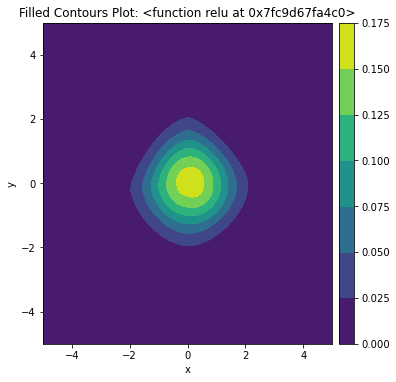

In [4]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([latent_dim], tf.float32))
flow_opt = tfk.optimizers.Adam(learning_rate=lr)
flow_model = IAF(base_dist, num_bijectors, hidden_units=[256, 256], ndims=latent_dim, activation=tf.nn.relu)
plot_contour_prob([flow_model], scale_fig=6, title=[tf.nn.relu])

## Build AutoEncoder & Train with Normalizing Flow

In [5]:
input_dim = X_train.shape[1]
encoder = ae.build_encoder(input_dim, latent_dim, hidden_units=[128, 64, 32])
decoder = ae.build_decoder(input_dim, latent_dim, hidden_units=[32, 64, 128])
autoencoder = ae.AutoEncoder(encoder, decoder, flow_model=flow_model, flow_opt=flow_opt)
autoencoder.compile()
history = autoencoder.fit(X_train, epochs=epochs, batch_size=None, verbose=1)

Epoch 1/50
597/597 [==============================] - 25s 12ms/step - reconstruction_loss: nan
Epoch 2/50
597/597 [==============================] - 7s 11ms/step - reconstruction_loss: nan
Epoch 3/50
597/597 [==============================] - 8s 13ms/step - reconstruction_loss: nan
Epoch 4/50
597/597 [==============================] - 6s 11ms/step - reconstruction_loss: nan
Epoch 5/50
597/597 [==============================] - 7s 11ms/step - reconstruction_loss: nan
Epoch 6/50
597/597 [==============================] - 6s 11ms/step - reconstruction_loss: nan
Epoch 7/50
597/597 [==============================] - 6s 11ms/step - reconstruction_loss: nan
Epoch 8/50
597/597 [==============================] - 6s 11ms/step - reconstruction_loss: nan
Epoch 9/50
597/597 [==============================] - 6s 11ms/step - reconstruction_loss: nan
Epoch 10/50
597/597 [==============================] - 6s 11ms/step - reconstruction_loss: nan
Epoch 11/50
597/597 [==============================] - 6s 

## Supervised Anomaly Classifier

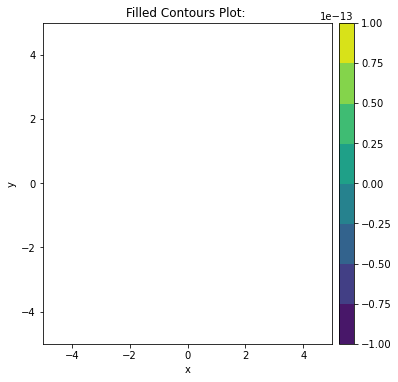

In [9]:
plot_contour_prob([flow_model], scale_fig=6)

In [ ]:
factor = 2
anomalies = sample_anomalies(flow_model, factor=factor, n_samples=3000, sample_shape=input_dim)
normals = sample_normals(flow_model, factor=factor, n_samples=10000, sample_shape=input_dim)

anomalies = pd.DataFrame(anomalies)
normals = pd.DataFrame(normals)
anomalies.columns = ['v1', 'v2']
normals.columns = ['v1', 'v2']
anomalies['label'] = 1
normals['label'] = 0

clr_data = pd.concat([anomalies, normals], axis=0)
clr_data = clr_data.dropna()
clr_data = shuffle(clr_data)

In [ ]:
clf_X_train, clf_X_test, clf_y_train, clf_y_test = train_test_split(clr_data[['v1', 'v2']], clr_data['label'], test_size=0.33, random_state=42)
clf, score = RFClassifier(clf_X_train, clf_y_train, clf_X_test, clf_y_test)
print('precision: {}'.format(score[0]))
print('recall: {}'.format(score[1]))
print('fscore: {}'.format(score[2]))
print('support: {}'.format(score[3]))

In [ ]:
X_data_latent = autoencoder.encoder.predict(X_data)
y_data_latent = clf.predict(X_data_latent)
y_data_latent_anomalies = np.where(y_data_latent == 1)
X_data_decoded = autoencoder.decoder.predict(X_data_latent)

In [ ]:
fig, axes = plt.subplots(2, figsize=(30,10))
x = np.arange(len(X_data_decoded[:, 0]))
axes[0].plot(x, X_data_decoded[:, 0], color='red', zorder=0)
axes[0].scatter(y_data_latent_anomalies, X_data_decoded[y_data_latent_anomalies, 0], s=10, color='blue', zorder=1)

axes[1].plot(x, X_data_decoded[:, 1], color='red', zorder=0)
axes[1].scatter(y_data_latent_anomalies, X_data_decoded[y_data_latent_anomalies, 1], color='blue', s=10, zorder=1)

plt.show()